# Advanced Classification Predict 

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>


In [35]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# needed for preprocessing
import re                                # library for regular expressions 
import string                            # for string operations 
import nltk
from nltk.corpus import stopwords        # module for stopwords that come with NLTK
from nltk.stem import PorterStemmer      # module for stemming 
from nltk.tokenize import TweetTokenizer # module for tokenizing strings 
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [2]:
# Load files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
samplesubmission = pd.read_csv('sample_submission.csv')

# Preview train dataset
train.head()


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [3]:
# Preview test dataset
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [4]:
# Preview sample submission file
samplesubmission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [5]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((15819, 3), (10546, 2), (10546, 2))

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

C:\Users\mac07\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


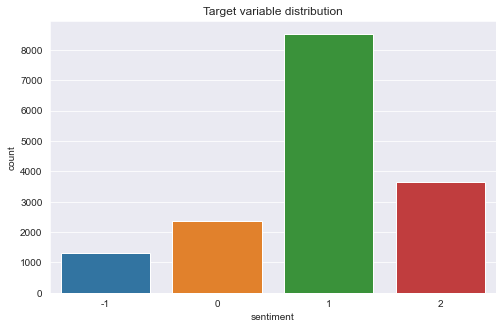

In [6]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["sentiment"])
plt.title('Target variable distribution')
plt.show()

The target variable is not well balanced.
Some of the techniques to handle imbalanceness include:
- Smote
- Oversampling
- Undersampling ...

In [7]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(False, False)

No missing values 

In [8]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

No duplicated values 

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### Cleaning the tweets

We have to me the following changes:
- Converting all Characters to Lowercase
- Remove Twitter handles
- Remove URLs
- Remove Hash signs
- Remove duplicate whitespace
- Remove 'rt' tags 

In [9]:
def clean(text):
    """
    Cleans text by removing usernames, RT, the hashtag symbol, and hyperlinks
    
    parameters:
    text: A string(a sequence of characters)
    
    returns:
    text: a string
    """
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Remove @mentions
    text = re.sub(r':[\s]+', '', text)
    text = re.sub(r'#', '', text) #Remove # symbol
    text = re.sub(r'rt[\s]+', '', text) #Remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove hyper-links
    
    return text

In [45]:
df = train.copy()
df_test = test.copy()

In [46]:
df['text'] = df['message'].apply(clean)
df_test['text'] = df_test['message'].apply(clean)

In [12]:
df.head()

,sentiment,message,tweetid,text
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,it's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,researchers say we have three years to act on ...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in ...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"it's 2016, and a racist, sexist, climate chang..."


### Tokenization

In [47]:
def tokenize(txt):
    """
    Splits a test into smaller units.
    
    Parameyters:
    txt: a string(a sequence of characters)
    
    returns:
    tokens: componets of a text
    """
    tokens = re.split('\W+', txt)
    return tokens
df['tokens'] = df['text'].apply(tokenize)
df_test['tokens'] = df_test['text'].apply(tokenize)

In [14]:
df.head()

,sentiment,message,tweetid,text,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn't think carbon di...,"[polyscimajor, epa, chief, doesn, t, think, ca..."
1,1,It's not like we lack evidence of anthropogeni...,126103,it's not like we lack evidence of anthropogeni...,"[it, s, not, like, we, lack, evidence, of, ant..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,researchers say we have three years to act on ...,"[researchers, say, we, have, three, years, to,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in ...,"[todayinmaker, wired, 2016, was, a, pivotal, y..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"it's 2016, and a racist, sexist, climate chang...","[it, s, 2016, and, a, racist, sexist, climate,..."


### Remove stopwords 

In [49]:
stoplist = set(stopwords.words("english"))

In [50]:
def remove_stopwords(txt_tokens):
    """
    Removes stop words from tokens
    
    Parameters:
    txt_tokens: components of a text
    
    Returns:
    txt_clean: a list containing tokens without stopwords
    """
    txt_clean = [word for word in txt_tokens if word not in stoplist]
    return txt_clean

df['no_stopwords'] = df['tokens'].apply(remove_stopwords)
df_test['no_stopwords'] = df_test['tokens'].apply(remove_stopwords)


In [51]:
df.head()

,sentiment,message,tweetid,text,tokens,no_stopwords
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn't think carbon di...,"[polyscimajor, epa, chief, doesn, t, think, ca...","[polyscimajor, epa, chief, think, carbon, diox..."
1,1,It's not like we lack evidence of anthropogeni...,126103,it's not like we lack evidence of anthropogeni...,"[it, s, not, like, we, lack, evidence, of, ant...","[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,researchers say we have three years to act on ...,"[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in ...,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, pivotal, year, war..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"it's 2016, and a racist, sexist, climate chang...","[it, s, 2016, and, a, racist, sexist, climate,...","[2016, racist, sexist, climate, change, denyin..."


### Lemmatization

In [18]:
wn = nltk.WordNetLemmatizer()

In [53]:
def lemmatization(no_stopwords):
    """
    Reduces words to their root form
    
    Parameters:
    no_stopwords: a list of words without stopwords
    
    Returns:
    text: a list with words which have been reduces to their root form
    """
    text = [wn.lemmatize(word) for word in no_stopwords]
    return text

df['lemmas'] = df['no_stopwords'].apply(lemmatization) #Adding the column lemmas to the df dataframe
df_test['lemmas'] = df_test['no_stopwords'].apply(lemmatization)

In [20]:
df.head()

,sentiment,message,tweetid,text,tokens,no_stopwords,lemmas
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn't think carbon di...,"[polyscimajor, epa, chief, doesn, t, think, ca...","[polyscimajor, epa, chief, think, carbon, diox...","[polyscimajor, epa, chief, think, carbon, diox..."
1,1,It's not like we lack evidence of anthropogeni...,126103,it's not like we lack evidence of anthropogeni...,"[it, s, not, like, we, lack, evidence, of, ant...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,researchers say we have three years to act on ...,"[researchers, say, we, have, three, years, to,...","[researchers, say, three, years, act, climate,...","[researcher, say, three, year, act, climate, c..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in ...,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, pivotal, year, war...","[todayinmaker, wired, 2016, pivotal, year, war..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"it's 2016, and a racist, sexist, climate chang...","[it, s, 2016, and, a, racist, sexist, climate,...","[2016, racist, sexist, climate, change, denyin...","[2016, racist, sexist, climate, change, denyin..."


### Take only the sentiment and the lemmatized columns

In [54]:
# create dataframe of lemmatized words and the sentiment
df = df[['sentiment', 'lemmas']]
df_test = df_test[['lemmas']]
df.head()

,sentiment,lemmas
0,1,"[polyscimajor, epa, chief, think, carbon, diox..."
1,1,"[like, lack, evidence, anthropogenic, global, ..."
2,2,"[researcher, say, three, year, act, climate, c..."
3,1,"[todayinmaker, wired, 2016, pivotal, year, war..."
4,1,"[2016, racist, sexist, climate, change, denyin..."


In [55]:
#Let’s convert the list into a string.
df['lemmas'] = [' '.join(map(str,l)) for l in df['lemmas']]
df_test['lemmas'] = [' '.join(map(str,l)) for l in df_test['lemmas']]
df.head()

,sentiment,lemmas
0,1,polyscimajor epa chief think carbon dioxide ma...
1,1,like lack evidence anthropogenic global warming
2,2,researcher say three year act climate change l...
3,1,todayinmaker wired 2016 pivotal year war clima...
4,1,2016 racist sexist climate change denying bigo...


### Transforming text to numbers

In [58]:
# Let's use the count vectorizer with its default hyperparameters
vect = CountVectorizer(max_features=1000)
X_count = vect.fit_transform(df['lemmas'].values.astype(str))
X_count_test = vect.fit_transform(df_test['lemmas'].values.astype(str))

In [59]:
X_count.shape

(15819, 1000)

In [60]:
vect.get_feature_names()

C:\Users\mac07\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '10',
 '100',
 '12',
 '2016',
 '2017',
 '30',
 '40',
 '50',
 '70',
 '80',
 '90',
 '97',
 'abortion',
 'absolutely',
 'accept',
 'accord',
 'according',
 'act',
 'action',
 'activist',
 'activity',
 'actonclimate',
 'actually',
 'ad',
 'adapt',
 'adaptation',
 'address',
 'addressing',
 'admin',
 'administration',
 'affect',
 'affected',
 'affecting',
 'africa',
 'age',
 'agency',
 'agenda',
 'ago',
 'agree',
 'agreement',
 'agriculture',
 'ahead',
 'air',
 'al',
 'alias',
 'almost',
 'already',
 'also',
 'alternative',
 'always',
 'america',
 'american',
 'amp',
 'anemone',
 'angry',
 'animal',
 'another',
 'answer',
 'antarctica',
 'anti',
 'anymore',
 'anyone',
 'anything',
 'approach',
 'arctic',
 'area',
 'argument',
 'around',
 'article',
 'ask',
 'asked',
 'attack',
 'auspol',
 'australia',
 'awareness',
 'away',
 'back',
 'bad',
 'ban',
 'barrier',
 'based',
 'basic',
 'battle',
 'bbc',
 'bc',
 'bear',
 'beat',
 'become',
 'bee',
 'beef',
 'beforetheflood',
 'begin',
 '

In [61]:
X = X_count.toarray()

In [62]:
y = df['sentiment']

In [63]:
# transform the dataset
oversample = SMOTE(random_state = 42)
X_res, y_res = oversample.fit_resample(X, y)

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=27)

# Here 'ovr' indicates that we have selected our One-vs-Rest strategy. 
logreg = LogisticRegression(multi_class='ovr')

logreg.fit(X_train, y_train)

# Generate predictions
y_pred = logreg.predict(X_test)

C:\Users\mac07\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mac07\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [65]:
# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.647274325908558


              precision    recall  f1-score   support

          -1       0.62      0.60      0.61      1655
           0       0.49      0.59      0.54      1669
           1       0.78      0.73      0.76      1755
           2       0.73      0.67      0.70      1745

    accuracy                           0.65      6824
   macro avg       0.66      0.65      0.65      6824
weighted avg       0.66      0.65      0.65      6824



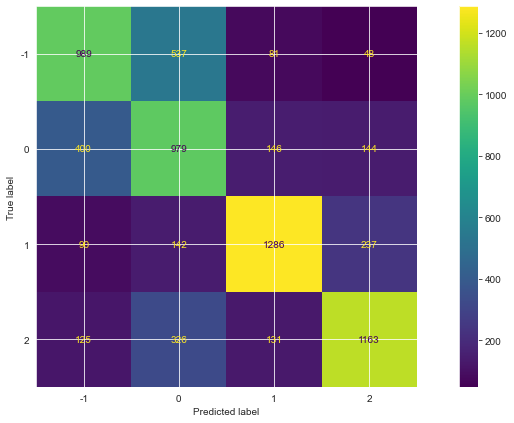

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

### Making predictions of the test set and creating a submission file

<ipython-input-67-cbbf00947941>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sub_file.Offset_fault = predictions
C:\Users\mac07\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


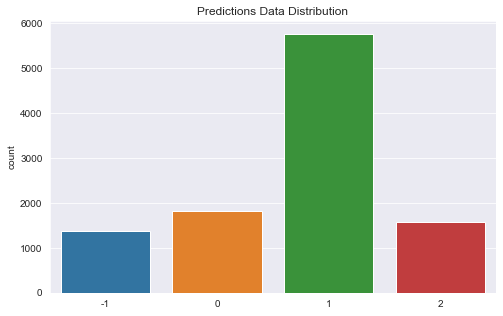

In [67]:
X_test = X_count_test.toarray()


predictions = logreg.predict(X_test)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

In [68]:
# Create file
sub_file.to_csv('BaseModel.csv', index = False)

<a id="seven"></a>
## 7. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>